In [1]:
from utils import bulk_retrieve_works, search_by_title, extract_pdf_text_from_url

In [2]:
from utils import bulk_retrieve_works, search_by_title, extract_pdf_text_from_url
from data_members import Node, Graph

In [3]:
%load_ext autoreload
%autoreload 2

### Getting search query and extracting references

In [4]:
title_query = "Motif Caller"

In [5]:
works = search_by_title(title_query)

In [12]:
def convert_work_to_node(work):

    node = Node()
    
    try:
        node.id = work['id'].rstrip('/').split('/')[-1]
        node.title = work['title']
        node.primary_topic = work['primary_topic']['display_name']
        #subfields = [i['display_name'] for i in work['primary_topic']['subfield']]
        node.topics = [i['display_name'] for  i in  work['topics']]
        node.keywords = [i['display_name'] for i in work['keywords']]
        node.total_citations = work['cited_by_count']
        node.publication_year = work['publication_year']
        node.has_fulltext = work['has_fulltext']
        node.doi = work['doi']
        node.authors = work['authorships']
        node.cites_by_id = [url.rstrip('/').split('/')[-1] for url in work['referenced_works']]
    except Exception as e:
        print(f"Exception {e}")

    return node


In [235]:
primary_node_2.title

'Motif Caller: Sequence Reconstruction for Motif-Based DNA Storage'

In [8]:
selected_work = works[2]

primary_node = convert_work_to_node(selected_work)

referenced_works = bulk_retrieve_works(primary_node.cites_by_id, extract_from_url=False)


In [10]:
referenced_works

[{'id': 'https://openalex.org/W2138270253',
  'doi': 'https://doi.org/10.1073/pnas.74.12.5463',
  'title': 'DNA sequencing with chain-terminating inhibitors',
  'display_name': 'DNA sequencing with chain-terminating inhibitors',
  'publication_year': 1977,
  'publication_date': '1977-12-01',
  'ids': {'openalex': 'https://openalex.org/W2138270253',
   'doi': 'https://doi.org/10.1073/pnas.74.12.5463',
   'mag': '2138270253',
   'pmid': 'https://pubmed.ncbi.nlm.nih.gov/271968',
   'pmcid': 'https://www.ncbi.nlm.nih.gov/pmc/articles/431765'},
  'language': 'en',
  'primary_location': {'is_oa': False,
   'landing_page_url': 'https://doi.org/10.1073/pnas.74.12.5463',
   'pdf_url': None,
   'source': {'id': 'https://openalex.org/S125754415',
    'display_name': 'Proceedings of the National Academy of Sciences',
    'issn_l': '0027-8424',
    'issn': ['0027-8424', '1091-6490'],
    'is_oa': False,
    'is_in_doaj': False,
    'is_indexed_in_scopus': True,
    'is_core': True,
    'host_organi

### Creating graph and nodes

In [13]:
referenced_nodes = [convert_work_to_node(i) for i in referenced_works]

Exception 'NoneType' object is not subscriptable


In [15]:
nodes = [primary_node] + referenced_nodes

In [16]:
graph = Graph(nodes = [primary_node] + referenced_nodes, primary_node=primary_node, search_query="Attention is all you need")

In [154]:
for i in nodes:
    i.position = get_random_position(scale_by=3)

In [141]:
nodes[0].position = (0.5, 0.5)

In [17]:
import random

In [18]:
def get_random_position(scale_by=1):
    return (random.random() * scale_by, random.random() * scale_by)

In [129]:
positions = {node.id: get_random_position() for node in graph.nodes}
#edges = [[(node.id, k) for k in node.cites_by_id if node.cites_by_id] for node in graph.nodes]
edges = [(primary_node.id, k) for k in primary_node.cites_by_id]

In [157]:
positions[graph.primary_node.id] = (1.5 ,1.5)

In [131]:
import matplotlib.pyplot as plt

### Cosine distance - getting relevance through the keywords

In [27]:

from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [26]:

from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(keywords1, keywords2):
    if not keywords1 or not keywords2:
        print("⚠ One paper has no keywords. Returning similarity=0.")
        return 0.0
    emb1 = embedder.encode(keywords1)
    emb2 = embedder.encode(keywords2)
    sims = cosine_similarity(emb1, emb2)
    return sims.max(axis=1).mean()

In [46]:
relevances = []

# Send it in a random direction based on how relevant it is
for i in graph.nodes:
    if hasattr(i, 'topics'):
        keywords1 = i.topics
        keywords2 = primary_node.topics
        relevances.append((1 - float(compute_similarity(keywords1, keywords2))))
    else:
        relevances.append(1.0)


c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

In [47]:
relevances

[0.0,
 0.44347816705703735,
 0.7276206910610199,
 1.0,
 0.4941890835762024,
 0.5481375455856323,
 0.7034974992275238,
 0.6467046737670898,
 0.6864245235919952,
 0.8682009130716324,
 0.44347816705703735,
 0.6704764068126678,
 0.4874061346054077,
 0.6124706864356995,
 0.8480959236621857,
 0.29642027616500854,
 0.601175993680954,
 0.25171732902526855,
 0.2733147144317627,
 0.7148004770278931]

### Weighting graph nodes 

In [45]:
def get_negative_number_random():
    return 1 if random.random() > 0.5 else -1

In [67]:
graph.positions = [
    (get_negative_number_random() * rel, get_negative_number_random() * rel) for rel in relevances]

In [68]:
positions = {node.id: position for node, position in zip(graph.nodes, graph.positions)}
edges = [(primary_node.id, k) for  k in primary_node.cites_by_id if k in [t.id for t in graph.nodes]]

In [57]:
positions

{'W2121016876': -0.0,
 'W2138270253': 0.44347816705703735,
 'W2432517183': 0.7276206910610199,
 'W2170120409': -1.0,
 'W2087064593': -0.4941890835762024,
 'W2119923823': -0.5481375455856323,
 'W2796837256': 0.7034974992275238,
 'W2325850497': 0.6467046737670898,
 'W2092784580': -0.6864245235919952,
 'W1969757078': -0.8682009130716324,
 'W2031928161': 0.44347816705703735,
 'W1992194142': -0.6704764068126678,
 'W2155008134': 0.4874061346054077,
 'W80436974': 0.6124706864356995,
 'W2306983420': -0.8480959236621857,
 'W2119464179': 0.29642027616500854,
 'W2528958959': 0.601175993680954,
 'W2132380334': 0.25171732902526855,
 'W2138942899': 0.2733147144317627,
 'W298913354': 0.7148004770278931}

In [ ]:
graph.relevances = relevances

positions = get_random_position()

In [72]:
positions.items()

dict_items([('W2121016876', (-0.0, 0.0)), ('W2138270253', (0.44347816705703735, 0.44347816705703735)), ('W2432517183', (0.7276206910610199, -0.7276206910610199)), ('W2170120409', (-1.0, 1.0)), ('W2087064593', (0.4941890835762024, 0.4941890835762024)), ('W2119923823', (0.5481375455856323, 0.5481375455856323)), ('W2796837256', (0.7034974992275238, -0.7034974992275238)), ('W2325850497', (-0.6467046737670898, 0.6467046737670898)), ('W2092784580', (-0.6864245235919952, -0.6864245235919952)), ('W1969757078', (0.8682009130716324, -0.8682009130716324)), ('W2031928161', (0.44347816705703735, 0.44347816705703735)), ('W1992194142', (0.6704764068126678, -0.6704764068126678)), ('W2155008134', (-0.4874061346054077, -0.4874061346054077)), ('W80436974', (0.6124706864356995, 0.6124706864356995)), ('W2306983420', (-0.8480959236621857, -0.8480959236621857)), ('W2119464179', (0.29642027616500854, -0.29642027616500854)), ('W2528958959', (0.601175993680954, 0.601175993680954)), ('W2132380334', (-0.251717329

In [75]:
import math

for id_, (x,y) in positions.items():
    r = abs(x)  # magnitude from origin
    theta = random.uniform(0, 2 * math.pi)  # random angle
    x = r * math.cos(theta)
    y = r * math.sin(theta)
    positions[id_] = (x, y)


In [76]:
positions

{'W2121016876': (-0.0, -0.0),
 'W2138270253': (-0.4429664355691153, -0.021298394668667404),
 'W2432517183': (0.4928408559840324, -0.5352940880796672),
 'W2170120409': (0.6073130196149576, -0.7944626461994058),
 'W2087064593': (0.4074634196443257, -0.2796362136377169),
 'W2119923823': (0.5098506809818644, -0.20126363800490732),
 'W2796837256': (0.17093013685880099, -0.6824160166150934),
 'W2325850497': (-0.31191826404650214, 0.5665103102560577),
 'W2092784580': (-0.3574304328318348, 0.5860222796738576),
 'W1969757078': (-0.6170605785081589, -0.6107446830792655),
 'W2031928161': (-0.323651589134436, 0.3031872911370524),
 'W1992194142': (0.10701831487786857, 0.6618804215061264),
 'W2155008134': (-0.47073505398023774, -0.12638531957948082),
 'W80436974': (-0.10678832893671118, -0.6030892094424519),
 'W2306983420': (0.7860794847986612, 0.3183484558013234),
 'W2119464179': (0.052189134621601754, 0.29178977766396863),
 'W2528958959': (0.2013427970652156, -0.5664571064504689),
 'W2132380334': 

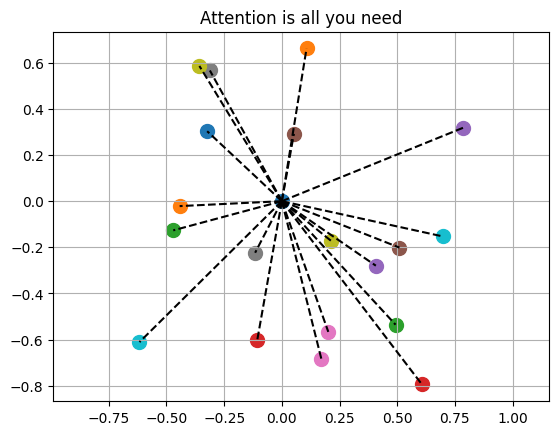

In [77]:
import matplotlib.pyplot as plt

for node, (x, y) in positions.items():
    plt.scatter(x, y, s=100)
    #plt.text(x + 0.1, y + 0.1, node)

for start, end in edges:
    if start in positions.keys() and end in positions.keys():
        x_values = [positions[start][0], positions[end][0]]
        y_values = [positions[start][1], positions[end][1]]
        plt.plot(x_values, y_values, 'k--', )
        plt.title(graph.search_query)

plt.axis('equal')
plt.grid(True)
plt.show()

In [80]:
for node, rel in zip(graph.nodes, relevances):
    theta = random.uniform(0, 2 * math.pi)  # random angle
    x = rel * math.cos(theta)
    y = rel * math.sin(theta)
    node.position = (x, y)

In [81]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go

# Dummy data (replace with actual Node instances)
from typing import List, Tuple, Any
from dataclasses import dataclass


# Create ID → Node map
id_node_map = {node.id: node for node in nodes}


edges = [(primary_node.id, k) for k in primary_node.cites_by_id if k in [a.id for a in graph.nodes]]

# Dash app
app = dash.Dash(__name__)

def build_figure(nodes: List[Node], edges: List[Tuple[str, str]]):
    edge_x, edge_y = [], []
    for source_id, target_id in edges:
        x0, y0 = id_node_map[source_id].position
        x1, y1 = id_node_map[target_id].position
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x, node_y, node_text, node_ids = [], [], [], []

    for node in nodes:
        x, y = node.position
        node_x.append(x)
        node_y.append(y)
        node_text.append(node.title)
        node_ids.append(node.id)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=[n.title for n in nodes],
        textposition="bottom center",
        marker=dict(size=20, color='skyblue', line_width=2),
        hoverinfo='text',
        customdata=node_ids  # For click callbacks
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Interactive Research Graph',
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))

    return fig

app.layout = html.Div([
    dcc.Graph(id='graph', figure=build_figure(nodes, edges)),
    html.Div(id='node-details', style={'whiteSpace': 'pre-line', 'padding': '20px', 'fontFamily': 'monospace'})
])

@app.callback(
    Output('node-details', 'children'),
    Input('graph', 'clickData')
)
def display_node_details(clickData):
    if clickData and "points" in clickData:
        point = clickData["points"][0]
        node_id = point["customdata"]
        node = id_node_map[node_id]
        return f"""
📄 Title: {node.title}
🔗 DOI: {node.doi}
📅 Year: {node.publication_year}
📈 Citations: {node.total_citations}
🏷️ Keywords: {node.keywords}
        """
    return "Click a node to view details."

if __name__ == '__main__':
    app.run(debug=True)


For one paper

- Get references
- populate nodes
- Linking based on ids
- Randomly distribute across space keep the main one in the centre
- Size of the nodes based on total citations

(later)
- Create graph - use very simple topic based space configuration - LLM call
